# Artifical Neural Networks from Scratch

## Introduction
The goal of this exercise is to demonstrate capabilities involving the understanding of NNs and tweaking of their hyperparameters to improve model performanace. Considering I have already done such 'NN 101' exercises many a times at Fontys, I decided to challenge myself by implementing them from scratch, using my own matrix and vector implementations. I did this because I like to balance my skills and understanding between the theoretical and the applied and believe that doing this will help with both. 

## Table of Contents
- Vectors
- Matrices
- Back and Forth prop
    - Minimal test case
- Wine dataset
    - Learning rate sanity check
    - Learning rate and model size tweaks
- Conclusion/Reflection


## Vectors

Before going over the implementation of these tensors, I should note that is not an attempt at a rival of numpy and the like regarding performance. In essence these vectors and matrices are glorified lists (of lists) (I attempted optimization with array.array() but that seems only fruitful if I were to completely redesign the code). This is primarily a learning exercise to deepen my comfort with and understanding of these mathematical tools and models.

That being said, here are the features of this implementation:
- Dot, cross, and hadamard product;
- Safe unwrapping of scalars (raises exception upon attempting to unwrap a vector of $n>1$)
- Operator (+, -, +, /) implementations for easier use;
- Random vector initalization with seed support (for constructing the same weights and biases accross tests);
- Transposition/column vectors (treated as $n \times 1$ matrix).

It is also worth noting that I have thoroughly tested these vector and matrix operations and their edgecases, but I didn't want to bulk up this file even more with those tests so I left them out of the notebook.

In [1]:
import operator
import random


def length_check(func):
    def wrapper(*args, **kwargs):
        if not isinstance(args[1], Vector):  # Vector +-/* int or float
            return func(*args, **kwargs)

        if len(args[0]) != len(args[1]):
            raise Exception(f"Tried to perform operator on differing length vectors ({args[0]}, {args[1]}).")
        
        return func(*args, **kwargs)
    return wrapper

def round_number(x: float, n_digits: int) -> str:
    if x.is_integer():
        return str(x)

    if len(str(x).split(".")[1]) > n_digits:
        return str(round(x, n_digits)) + "…"
        
    return str(x)

class Vector:
    __slots__ = ['values', '_len']
    n_digits_clamp = 4

    def __init__(self, values: iter):
        self.values = list(values)
        self._len = len(values)

    def __len__(self) -> int:
        return self._len

    def __getitem__(self, i) -> int | float:
        return self.values[i]

    def __iter__(self):
        return self.values.__iter__()

    def transpose(self):
        return Matrix([Vector([x]) for x in self.values])

    def copy(self) -> "Vector":
        return Vector(self.values)

    @staticmethod
    def filled(length: int, value: float) -> "Vector":
        return Vector([value] * length)
    
    @staticmethod
    def random(length: int, seed: int | None = None) -> "Vector":
        random.seed(seed)
        return Vector([random.random() for _ in range(length)])

    def dotprod(self, other) -> int:
        if len(self) == 1:
            return other * self[0]  # Handling it as matrix multiplication.

        if len(self) != len(other):
            raise Exception(f"Tried to perform operator on differing length vectors ({self}, {other}).")

        return sum(self[i] * other[i] for i in range(len(self)))

    @length_check
    def crossprod(self, other) -> "Vector":
        if len(self) != 3:
            raise Exception("Cross products are only implemented for the case of len 3.")

        return Vector([self[1] * other[2] - self[2] * other[1],
                       self[2] * other[0] - self[0] * other[2],
                       self[0] * other[1] - self[1] * other[0]])

    def unwrap(self) -> float:
        if len(self) > 1:
            raise Exception("Tried to unwrap vector of length", len(self))

        return self[0]

    @length_check
    def _element_wise_operation(self, other, operand) -> "Vector":
        if isinstance(other, Vector):
            return Vector([operand(self[i], other[i]) for i in range(len(self))])

        return Vector([operand(x, other) for x in self])

    def __add__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.add)

    def __radd__(self, other):
        return self + other

    def __sub__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.sub)

    def __rsub__(self, other):
        return self - other

    def __truediv__(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.truediv)

    def __rtruediv__(self, other):
        return self / other

    def __mul__(self, other) -> "Vector":
        if isinstance(other, Vector):
            return self.dotprod(other)
        if isinstance(other, Matrix):
            return NotImplemented

        return Vector([x * other for x in self]) 
    
    def __rmul__(self, other):
        return self * other

    def __repr__(self):
        return "[" +  ", ".join([round_number(x, Vector.n_digits_clamp) for x in self.values]) + "]"

    def __abs__(self) -> "Vector":
        return Vector([abs(x) for x in self.values])

    def hadamard(self, other) -> "Vector":
        return self._element_wise_operation(other, operator.mul)

## Matrices

In [2]:
def shape_check(func):
    def wrapper(*args, **kwargs):
        if not isinstance(args[1], Matrix):  # Vector +-/* int or float
            return func(*args, **kwargs)

        if args[0].shape != args[1].shape:
            raise Exception(f"Tried to get the dot product of differently shaped matrices ({args[0].shape, args[1].shape}).")
        
        return func(*args, **kwargs)
    return wrapper


def matrix_mul(self, other):  # Kinda messy, but better than duplication for edgecases with __rmul__().
    if not isinstance(other, Matrix):
        return Matrix([x * other for x in self])

    if self.shape[0] != other.shape[1]:
        raise Exception(f"Tried to multiply matrices of unsupported shapes ({self.shape}, {other.shape})")

    other_tp = other.transpose()
    return Matrix([[x.dotprod(y) for y in other_tp] for x in self])


# IMPORTANT: values is a list of rows, so len(val) = n_rows and len(val[0]) = n_cols.
class Matrix:
    __slots__ = ['values', 'shape']

    def __new__(cls, values):  # 1 row matrix -> vector coercion.
        if len(values) == 1:
            return Vector(values[0])
        return super().__new__(cls)
        
    def __init__(self, values):
        if any(len(values[0]) != len(values[i]) for i in range(1, len(values))):
            raise ValueError(f"Mismatching rows lengths for matrix ({[len(x) for x in values]}).")
            
        self.values = [Vector(row) if not isinstance(row, Vector) else row for row in values]
        self.shape = (len(self.values), len(values[0]))

    def __getitem__(self, i) -> Vector:
        return self.values[i]

    def __iter__(self):
        return self.values.__iter__()
        
    @staticmethod
    def filled(n_rows: int, n_cols: int, value: float) -> "Matrix":
        return Matrix([Vector.filled(n_cols, value) for _ in range(n_rows)])
        
    @staticmethod
    def random(n_rows: int, n_cols: int, seed: int = None) -> "Vector":
        return Matrix([Vector.random(n_cols, seed) for _ in range(n_rows)])

    def copy(self) -> "Matrix":
        return Matrix(*[x.copy() for x in self])

    def transpose(self) -> "Matrix":
        return Matrix([Vector(x) for x in zip(*self)])
    
    def determinant(self) -> float:
        n_rows, n_cols = self.shape

        if n_rows != n_cols:
            raise Exception("Determinants are only supported for square matrices.")
            
        if n_rows == 1:
            return self[0][0]
        if n_rows == 2:
            return self[0][0] * self[1][1] - self[0][1] * self[1][0]
        
        # Laplace expansion along first row.
        def cofactor(j: int) -> float:
            # Excluding first row and current column.
            minor = [[self[i][k] for k in range(n_cols) if k != j] 
                     for i in range(1, n_rows)]

            return self[0][j] * ((-1) ** j) * Matrix(minor).determinant()
        
        return sum(cofactor(j) for j in range(n_cols))

    @shape_check
    def _element_wise_operation(self, other, operand) -> "Matrix":
        if isinstance(other, Matrix):
            return Matrix([operand(self[i], other[i]) for i in range(self.shape[0])])
                         
        return Matrix([operand(x, other) for x in self])

    def __add__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.add)

    def __radd__(self, other):
        return self + other

    @shape_check
    def __truediv__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.truediv)

    def __rtruediv__(self, other):
        return self / other

    @shape_check
    def __sub__(self, other) -> "Matrix":
        return self._element_wise_operation(other, operator.sub)

    def __rsub__(self, other):
        return self - other

    def __mul__(self, other):
        if isinstance(other, Vector):  # Treat as row vector
            return Matrix([Vector([row.unwrap() * x for x in other]) for row in self])

            # Treat vector as column vector (Nx1)
            if self.shape[1] != len(other):
                raise Exception(f"Incompatible shapes for matrix-vector multiplication: {self.shape} and {len(other)}")
            return Vector([row.dotprod(other) for row in self])
        return matrix_mul(self, other)

    def __rmul__(self, other):
        if isinstance(other, Vector):
            # Treat vector as 1xN matrix multiplying an NxM matrix
            return Vector([sum(other[i] * self[i][j] for i in range(len(other))) 
                          for j in range(len(self[0]))])
        return matrix_mul(other, self)

    def __repr__(self):
        return "\n".join(str(x) for x in self)

    def hadamard(self, other) -> "Matrix":
        return self._element_wise_operation(self, other, operator.mul)

## Neural Network
Performance is not the primary goal of this exercise and it would take a lot of changes to update the parameters in parallel batches using the GPU. That's why this implementation makes use of online training, which also makes the model more memory efficient, although I am aware of the added benefit of more stable learning in batch training via the use of means over many runs.

For use of the model we define a list $l$ of length $L$, where $l_i =$ the size of each layer of the network. $X$ and $Y$ are of course vectors of size $l_0$ and $l_{L-1}$ respectively. Using $l$, the weights and biases can be shaped as follows:

$$W_i = M_{l_{i-1}, l_i} \text{ for } i > 0, \hspace{0.5cm} B_i = M_{1, l_i} \text{ for } i > 0$$

with the parameters inside the weights and biases being random values between $0$ and $1$.

### Forward Propegation
FP was implemented in accordance with the following formulae, with each intermittent value of $z$ and $A$ being saved for BP:

$$z_i = \begin{cases}
X \cdot W_i + B_i  & i = 1 \\
f_{i-1}(z_{i-1}) \cdot W_i + B_i  & i \gt 1 
\end{cases}$$

$$A_i = \begin{cases}
X & i = 0 \\
f_i(z_i) & i \gt 0
\end{cases}$$

where, of course, $\hat{Y} = A_L$.


### Backward Propegation
$$\partial z_i = \begin{cases}
A_L - Y  & i = L \\
(\partial z_{i+1} \cdot W^T_{i+1}) \partial f_i (z_i) & 0 \lt i \lt L 
\end{cases}$$

$$\partial W_i = \frac{A^T_{i-1} \cdot \partial z_i}{n}$$
$$\partial B_i = \frac{\partial z_i}{n}$$


#### Gradient Descent
After calculating the partial derivatives of the parameters, they can be adjusted using gradient descent and the learning rate $\alpha$.

$$W_i = W_i - \partial W_i \cdot \alpha$$
$$B_i = B_i -\partial B_i \cdot \alpha$$

### MSE
During the backpropegation the MSE is also saved for each run, which is calculated as follows:
$$MSE=\frac{e^Te}{n} \text{, where }e=\hat{Y} - Y$$

In [3]:
from functools import reduce
import operator


class ANN:
    def __init__(self, layer_sizes: list[int], activation_funcs: list["Function"], /, alpha: float, 
                 endlabels: list = None, seed: int = None, param_default_val: float = None):
        if param_default_val:
            self.weights = [Matrix.filled(x, y, param_default_val) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
            self.biases = [Vector.filled(x, param_default_val) for x in layer_sizes[1:]]
        else:
            self.weights = [Matrix.random(x, y, seed) for x, y in zip(layer_sizes[:-1], layer_sizes[1:])]
            self.biases = [Vector.random(x, seed) for x in layer_sizes[1:]]
            
        self.activation_funcs = [Identity] + activation_funcs
        self.alpha = alpha

        self.last_run_z = []  # Saved for backprop.
        self.last_run_A = []  # Saved for backprop.
        
        self.MSEs = []
        self.corrects = []

        self._epoch_counter = 0

        self.endlabels = endlabels
        if endlabels and len(endlabels) != layer_sizes[-1]:
            raise Exception("Number of endlabels doesn't match length of output layer.")

    def __repr__(self):
        weights_str = "\n".join(f"{w}\n" for w in self.weights)
        biases_str = "\n".join(f"{b}\n" for b in self.biases)
        return f"Weights:\n{weights_str}\n\nBiases:\n{biases_str}\n"

    def train(self, features: list[Vector], labels: list[Vector], eval_func: callable = None, interval_k: int = 1000) -> dict:
        self.MSEs = []
        self.corrects = []

        n = len(features)
        for f, l in zip(features, labels):
            _ = self.predict(f)

            self.backprop_gd(l, n, eval_func)
            self._epoch_counter += 1

            if self._epoch_counter % interval_k == 0:
                print(f"Training at {self._epoch_counter} epochs.")

    def predict(self, features: Vector) -> list | dict:
        self.last_run_z = []
        self.last_run_A = []
        z = features

        for weights, biases, activ, in zip(self.weights, self.biases, self.activation_funcs):
            A = activ.compute(z)
            z = A * weights + biases
            self.last_run_A.append(A)
            self.last_run_z.append(z)

        A = self.activation_funcs[-1].compute(z)  # TODO: Better loop so this last case doesn't have to be excluded(?)
        self.last_run_A.append(A)

        return dict(zip(self.endlabels, A)) if self.endlabels else A

    def backprop_gd(self, labels: Vector, n: int, eval_func: callable = None):
        if eval_func:
            A = self.last_run_A[-1]
            last_out = dict(zip(self.endlabels, A)) if self.endlabels else A
            self.corrects.append(eval_func(last_out, labels))
        
        e = self.last_run_A[-1] - labels
        self.MSEs.append((e * e.transpose() / n).unwrap())

        z_partials = [e]  # z_L = A_L - Y

        for i in range(len(self.weights) - 1, 0, -1):  # Backward from L-1 to 1.
            z = self.last_run_z[i - 1]  # Z from current layer.
            weights = self.weights[i]  # Weights from next layer.
            activ = self.activation_funcs[i]  # Activation from current layer.

            # Calculate partial using the formula: (∂z_{l+1} · W_{l+1}^T) ⊙ f'(z_l)
            z_partial = (z_partials[-1] * weights.transpose()).hadamard(activ.compute_deriv(z))
            z_partials.append(z_partial)

        z_partials = list(reversed(z_partials))

        w_partials = [A.transpose() * z_p / n for A, z_p in zip(self.last_run_A, z_partials)]

        b_partials = [z / n for z in z_partials]

        self.weights = [w - w_p * self.alpha for w, w_p in zip(self.weights, w_partials)]
        self.biases = [b - b_p * self.alpha for b, b_p in zip(self.biases, b_partials)]

### Functions
Before creating an instance we need to define the functions such as ReLU and Sigmoid.

In [4]:
class Function:
    def __init__(self, name: str, func: callable, derivative: callable):
        self.name = name
        self.func = func
        self.deriv = derivative

    def compute(self, data: Vector) -> Vector:
        return Vector([self.func(x) for x in data])

    def compute_deriv(self, data: Vector) -> Vector:
        return Vector([self.deriv(x) for x in data])

ReLU = Function(name="ReLU",
                func=lambda x: x if x > 0 else 0,
                derivative=lambda x: int(x > 0))


from math import e
sig = lambda x: 1 / (1 + e ** (-x))

def sig_deriv(x: float) -> float:
    sig_x = sig(x)  # Put this in a 'full func' and not a lambda to prevent calculating this twice.
    return sig_x * (1- sig_x)

Sigmoid = Function(name="Sigmoid",
                   func=sig,
                   derivative=sig_deriv)

Identity = Function(name="Identity",  # Used as 'activation function' for first layer. 
                    func=lambda x: x,
                    derivative=lambda x: 1)

### Minimal test case
One iteration of FP and BP will be done on a small model and also calculated manually to ensure they reconcile.

$$l=[2, 3, 1] \text{, } X=[0.5, 0.8] \text{, } Y=[0.4] \text{, } \alpha = 0.1$$
\
$$W_1 = \begin{bmatrix}
0.5 & 0.5 & 0.5 \\
0.5 & 0.5 & 0.5
\end{bmatrix} \text{, } W_2 = \begin{bmatrix}
0.5 \\
0.5 \\
0.5
\end{bmatrix}$$

$$B_1 = [0.5, 0.5, 0.5] \text{, } B_2 = [0.5]$$

$$f=[\text{ReLU, Sigmoid}]$$


#### One Step Forward
$$z_1 = [0.5, 0.8] \cdot \begin{bmatrix}
0.5 & 0.5 & 0.5 \\
0.5 & 0.5 & 0.5
\end{bmatrix} + [0.5, 0.5, 0.5] = [0.65, 0.65, 0,65] + [0.5, 0.5, 0.5] = [1.15, 1.15, 1.15]$$

$$A_1 = ReLU([1.15, 1.15, 1.15]) = [1.15, 1.15, 1.15]$$

$$z_2 = [1.15, 1.15, 1.15] \cdot \begin{bmatrix}
0.5 \\
0.5 \\
0.5
\end{bmatrix} + [0.5] = [1.725] + [0.5] = [2.225]$$

$$\hat{Y} = A_2 = Sigmoid([2.225]) = [0.902...] \approx [0.9]$$


#### And One Back
$$\partial z_2 = [0.9] - [0.4] = [0.5]$$
$$\partial z_1 = ([0.5] \cdot [0.5, 0.5, 0.5]) ReLU'([1.15, 1.15, 1.15]) = [0.25, 0.25, 0.25] \cdot [1, 1, 1] = [0.25, 0.25, 0.25]$$
\
$$\partial W_2 = \frac{\begin{bmatrix}
1.15 \\
1.15 \\
1.15
\end{bmatrix} \cdot [0.5]}{1} = \begin{bmatrix}
0.575 \\
0.575 \\
0.575
\end{bmatrix}$$

$$\partial W_1 = \frac{\begin{bmatrix}
0.5 \\
0.8
\end{bmatrix} \cdot [0.25, 0.25, 0.25]}{1} = \begin{bmatrix}
0.125 & 0.125 & 0.125 \\
0.2 & 0.2 & 0.2
\end{bmatrix}$$
\
$$\partial B_2 = \frac{[0.5]}{1} = [0.5]$$
$$\partial B_1 = \frac{[0.25, 0.25, 0.25]}{1} = [0.25, 0.25, 0.25]$$

#### Gradient Descent
$$W_1 = \begin{bmatrix}
0.5 & 0.5 & 0.5 \\
0.5 & 0.5 & 0.5
\end{bmatrix} - \begin{bmatrix}
0.125 & 0.125 & 0.125 \\
0.2 & 0.2 & 0.2
\end{bmatrix} \cdot 0.1 = \begin{bmatrix}
0.4875 & 0.4875 & 0.4875 \\
0.48 & 0.48 & 0.48
\end{bmatrix}$$

$$W_2 = \begin{bmatrix}
0.5 \\
0.5 \\
0.5
\end{bmatrix} - \begin{bmatrix}
0.575 \\
0.575 \\
0.575
\end{bmatrix} \cdot 0.1 = \begin{bmatrix}
0.4425 \\
0.4425 \\
0.4425
\end{bmatrix}$$



$$B_1 = [0.5, 0.5, 0.5 - [0.25, 0.25, 0.25] \cdot 0.1 = [0.475, 0.475, 0.475]$$
$$B_2 = [0.5] - [0.5] \cdot 0.1 = [0.45]$$


In [5]:
layer_sizes = [2, 3, 1]
activation_funcs = [ReLU, Sigmoid]
alpha = 0.1

X = Vector([0.5, 0.8])
Y = Vector([0.4])

nn = ANN(layer_sizes, activation_funcs, alpha=alpha, param_default_val=0.5)

print("Before", nn, "", sep="\n")

print("Prediction:", nn.predict(X))

nn.backprop_gd(Y, n=1)
print("After", nn, sep="\n")

Before
Weights:
[0.5, 0.5, 0.5]
[0.5, 0.5, 0.5]

[0.5]
[0.5]
[0.5]


Biases:
[0.5, 0.5, 0.5]

[0.5]



Prediction: [0.9025…]
After
Weights:
[0.4874…, 0.4874…, 0.4874…]
[0.4799…, 0.4799…, 0.4799…]

[0.4422…]
[0.4422…]
[0.4422…]


Biases:
[0.4749…, 0.4749…, 0.4749…]

[0.4498…]




Of course the manual calculation rounded down $\hat{Y}$ to $0.9$, which is why the real numbers are slightly different - and a whole lot less clean, but with that in mind the model appears to be working perfectly.

## Wine Quality Prediction
For the training/optimizing part of this exercise I chose the Wine quality dataset ***LINK HERE SOURCE***.

The dataset consists of 11 attributes of the wine and a quality rating (3-8). The quality rating could be represented by either a single neuron in the output layer (ideally outputting 0.3-0.8), or by 6 neurons representing 3-8 respectively. Both will be tested, but with the latter it is likely easier to express the revelant patterns since the entire model before it won't be fighting for control over the single output neuron (which is also more suspeptible to noise, especially considering the dataset is only ~1600 entries).

In [6]:
features, labels_reg, labels_class = [], [], []
qualities = list(range(3, 9))
with open('WineQT.csv', 'r') as f:
    for line in f.readlines()[1:]:
        *feat, label, _ = line.split(',')

        features.append(Vector([float(f) for f in feat]))
        labels_reg.append(Vector([float(label) / 10]))
        labels_class.append(Vector([float(int(label) == q) for q in qualities]))
import pandas as pd

print(pd.read_csv('WineQT.csv').head(3))

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   

   alcohol  quality  Id  
0      9.4        5   0  
1      9.8        5   1  
2      9.8        5   2  


In [7]:
def argmax_label(d: dict) -> str:
    # return the key of which the value is highest of all values
    return [label for label in d if d[label] == max(d.values())][0]


def reg_correct(pred: Vector, label: Vector) -> bool:
    return round(label.unwrap() * 10) == round(pred.unwrap() * 10)

    
def class_correct(pred: Vector, label: Vector) -> bool:
    return argmax_label(dict(zip(list(range(3, 9)), label))) == argmax_label(pred)

In [8]:
from sklearn.model_selection import train_test_split

activation_funcs = [ReLU, Sigmoid]
alpha = 0.16

nn_class = ANN([11, 8, 6], activation_funcs, 
               alpha=alpha, 
               param_default_val=0.5, 
               endlabels=list(range(3, 9)))
nn_reg = ANN([11, 8, 1], activation_funcs, 
             alpha=alpha, 
             param_default_val=0.5)

training_features, testing_features, training_labels_reg, \
testing_labels_reg, training_labels_class, testing_labels_class = train_test_split(features, labels_reg, labels_class,
                                                                                   random_state=1,
                                                                                   test_size=0.15,
                                                                                   shuffle=True)

nn_class.train(training_features, training_labels_class, eval_func=class_correct)
nn_reg.train(training_features, training_labels_reg, eval_func=reg_correct)

<Axes: ylabel='Proportion'>

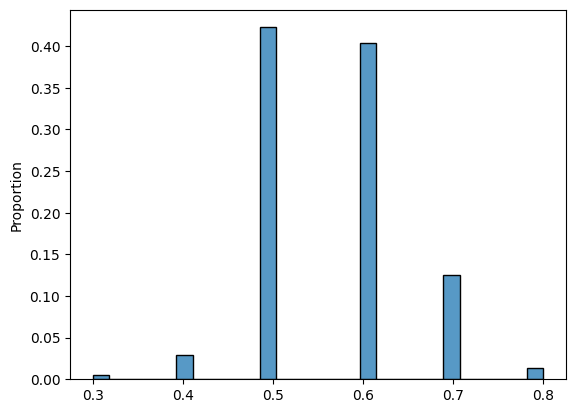

In [9]:
import seaborn as sns

sns.histplot([x[0] for x in labels_reg], stat="proportion")

***EXPLAIN SCALAR 24***

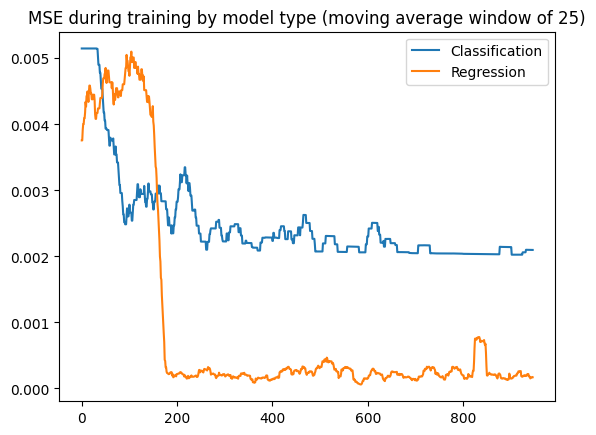

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def moving_average(a, n=3):
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

mov = 25
sns.lineplot({"Classification": moving_average(nn_class.MSEs, mov),
              "Regression": [x*24 for x in moving_average(nn_reg.MSEs, mov)]}, dashes=False)

plt.title(f"MSE during training by model type (moving average window of {mov})")
# plt.yscale('log')
plt.show()

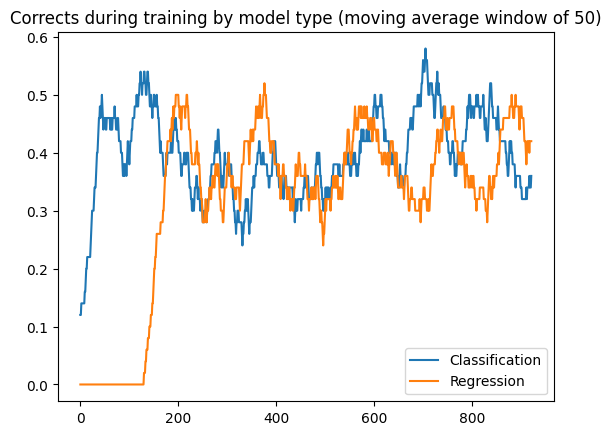

In [11]:
mov = 50
sns.lineplot({"Classification": moving_average(nn_class.corrects, mov),
              "Regression": moving_average(nn_reg.corrects, mov)}, dashes=False)

plt.title(f"Corrects during training by model type (moving average window of {mov})")
plt.show()

In [12]:
ANN([11, 8, 1], activation_funcs, 
    alpha=alpha, 
    param_default_val=0.5).predict(testing_features[0])

[1.0]

***REGRESSION IS PEGGED TO 10 FROM START -> AUTOFAIL, CLASSIFICATION HAS A 1/6 CHANCE***

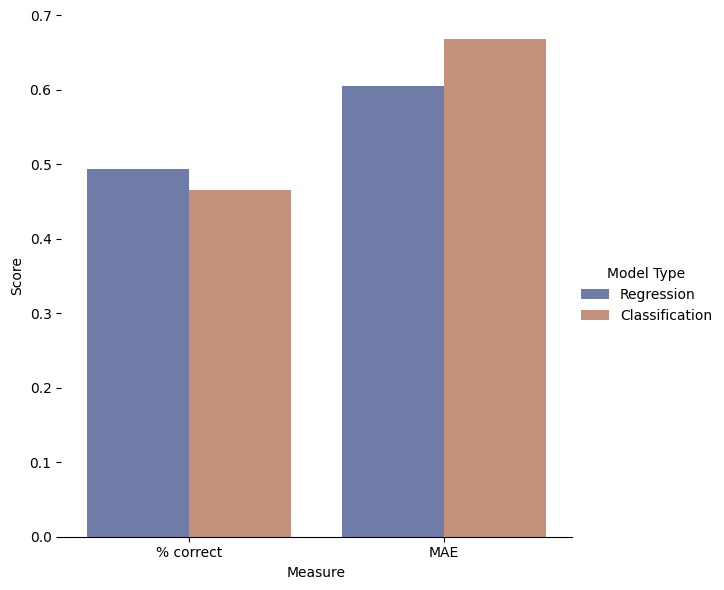

In [13]:
import pandas as pd


correct = {"reg": 0, "class": 0}
MAE = {"reg": 0, "class": 0}
for feat, label_reg, label_class in zip(testing_features, testing_labels_reg, testing_labels_class):
    label = round((label_reg * 10).unwrap())
    pred_reg = round((nn_reg.predict(feat) * 10).unwrap())
    pred_class = argmax_label(nn_class.predict(feat))

    correct["reg"] += label == pred_reg
    correct["class"] += label == pred_class

    MAE["reg"] += abs(label - pred_reg)
    MAE["class"] += abs(label - pred_class)
    
    # print(f"Label: {label},  reg pred: {pred_reg}, class pred: {pred_class}")

correct = {k: v / len(testing_features) for k, v in correct.items()}
MAE = {k: v / len(testing_features) for k, v in MAE.items()}

df = pd.DataFrame.from_dict({"Model": ["Regression", "Regression", "Classification", "Classification"],
                             "Measure": ["% correct", "MAE", "% correct", "MAE"],
                             "Score": [correct["reg"], MAE["reg"], correct["class"], MAE["class"]]})

g = sns.catplot(
    data=df, kind="bar",
    x="Measure", y="Score", hue="Model",
    errorbar="sd", palette="dark", alpha=.6, height=6)
g.despine(left=True)
g.legend.set_title("Model Type")

## Learning Rate

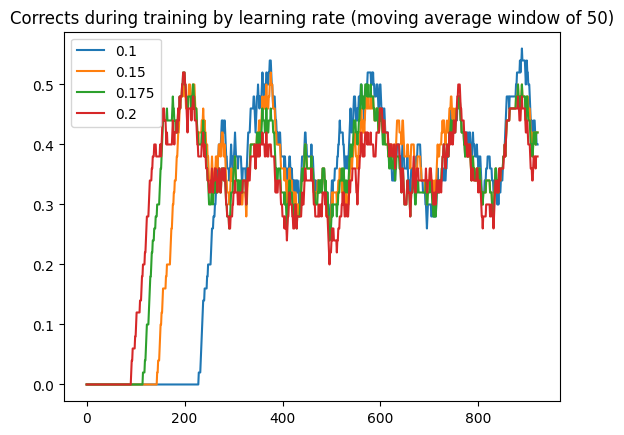

In [14]:
layer_sizes = [11, 8, 1]
activation_funcs = [ReLU, Sigmoid]

epochs = {}
for alpha in (0.1, 0.15, 0.175, 0.2):
    nn_reg = ANN(layer_sizes, activation_funcs, 
                 alpha=alpha, 
                 param_default_val=0.5)
    
    nn_reg.train(training_features, training_labels_reg, eval_func=reg_correct)
    epochs[alpha] = nn_reg.corrects

mov = 50
sns.lineplot({k: moving_average(v, mov) for k, v in epochs.items()}, dashes=False)

plt.title(f"Corrects during training by learning rate (moving average window of {mov})")
plt.show()

We can clearly see that the learning rate has significant effect on escaping that '1.0 bias' discussed earlier, but what is more interesting is that (looking at the peaks of accuracy during training) $\alpha = 0.15$ seems to be as hard as can be pushed without really losing accuracy accross the board due to sensitivity to noise. 

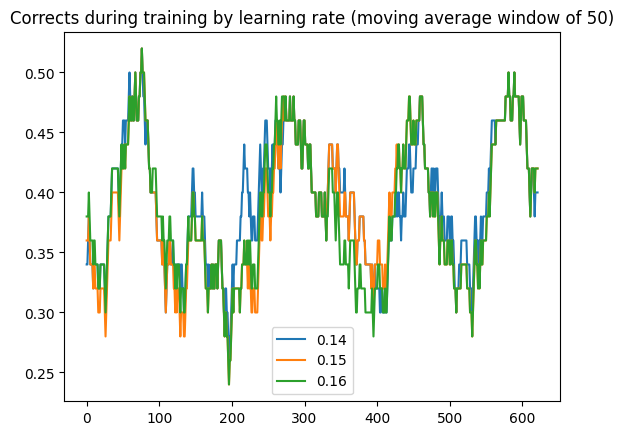

In [15]:
layer_sizes = [11, 8, 1]
activation_funcs = [ReLU, Sigmoid]

offset = 300
epochs = {}
for alpha in (0.14, 0.15, 0.16):
    nn_reg = ANN(layer_sizes, activation_funcs, 
                 alpha=alpha, 
                 param_default_val=0.5)
    
    nn_reg.train(training_features, training_labels_reg, eval_func=reg_correct)
    epochs[alpha] = nn_reg.corrects[offset:]

mov = 50
sns.lineplot({k: moving_average(v, mov) for k, v in epochs.items()}, dashes=False)

plt.title(f"Corrects during training by learning rate (moving average window of {mov})")
plt.show()

***NEGLIGABLE***

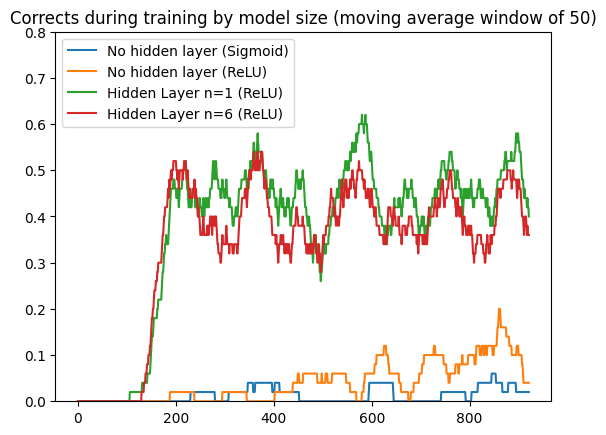

In [16]:
layer_sizes = ([11, 1], [11, 1], [11, 1, 1], [11, 6, 1])
labels = ["No hidden layer" if len(l) == 2 else f"Hidden Layer n={l[1]}" for l in layer_sizes]
activation_funcs = ([Sigmoid], [ReLU], [ReLU, Sigmoid], [ReLU, Sigmoid])
alpha = 0.16

epochs = {}
for l, a, label in zip(layer_sizes, activation_funcs, labels):
    nn_reg = ANN(l, a, 
                 alpha=alpha, 
                 param_default_val=0.5)
    
    nn_reg.train(training_features, training_labels_reg, eval_func=reg_correct)
    epochs[label + f" ({nn_reg.activation_funcs[1].name})"] = nn_reg.corrects

mov = 50
sns.lineplot({k: moving_average(v, mov) for k, v in epochs.items()}, dashes=False)

ax = plt.gca()
ax.set_ylim(0,0.8)
plt.title(f"Corrects during training by model size (moving average window of {mov})")
plt.show()

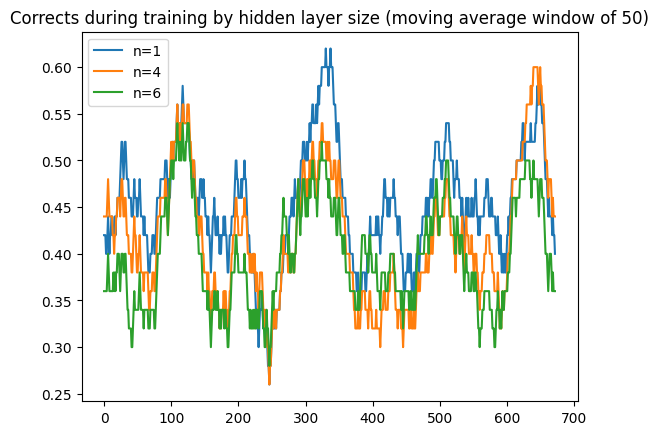

In [17]:
layer_sizes = ([11, 1, 1], [11, 4, 1], [11, 6, 1])
labels = [f"n={l[1]}" for l in layer_sizes]
activation_funcs = ([ReLU, Sigmoid], [ReLU, Sigmoid], [ReLU, Sigmoid])
alpha = 0.16

offset = 250
epochs = {}
for l, a, label in zip(layer_sizes, activation_funcs, labels):
    nn_reg = ANN(l, a, 
                 alpha=alpha, 
                 param_default_val=0.5)
    
    nn_reg.train(training_features, training_labels_reg, eval_func=reg_correct)
    epochs[label] = nn_reg.corrects[offset:]

mov = 50
sns.lineplot({k: moving_average(v, mov) for k, v in epochs.items()}, dashes=False)

plt.title(f"Corrects during training by hidden layer size (moving average window of {mov})")
plt.show()

***1 IS BEST?***

## Conclusion and Reflection